In [1]:
from Dataset import *
from Model_Setting import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')
% matplotlib inline

Using TensorFlow backend.


In [2]:
embedding_index, vtr_dim = import_glove(25)

In [3]:
col_fire_12 = dataset('2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv')
col_flood_13 = dataset('2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv')
aus_fire_13 = dataset('2013_Australia_bushfire/2013_Australia_bushfire-tweets_labeled.csv')
aus_flood_13 = dataset('2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv')
col_fire_12_g = col_fire_12.glove(embedding_index, vtr_dim)
col_flood_13_g = col_flood_13.glove(embedding_index, vtr_dim)
aus_fire_13_g = aus_fire_13.glove(embedding_index, vtr_dim)
aus_flood_13_g = aus_flood_13.glove(embedding_index, vtr_dim)
col_fire_12_lb = to_categorical(col_fire_12.df.label)
col_flood_13_lb = to_categorical(col_flood_13.df.label)
aus_fire_13_lb = to_categorical(aus_fire_13.df.label)
aus_flood_13_lb = to_categorical(aus_flood_13.df.label)

In [20]:
def create_lstm_model(bidir=True, n_lstm=32, dropout=0.3, re_dropout=0.3, penalty=0.01, input_shape=25):
    model = Sequential()
    if bidir:
        model.add(Bidirectional(LSTM(n_lstm, kernel_initializer='he_normal', recurrent_dropout=re_dropout, dropout=dropout, 
                                     kernel_regularizer=regularizers.l2(penalty)),input_shape=(None,input_shape)))
    else:
        model.add(LSTM(n_lstm, kernel_initializer='he_normal', recurrent_dropout=re_dropout, dropout=dropout, 
                                     kernel_regularizer=regularizers.l2(penalty),input_shape=(None,input_shape)))
    #model.add(Dense(64, activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(penalty)))
    #model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
def incremental_learning_prob(model, tweets, step=10, threshold=0.75):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= threshold or y_pred[j][1] >= threshold])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= threshold or y_pred[j][1] >= threshold]
        label = to_categorical(map(lambda x: 0 if x[0]>=threshold else 1, y_confident))
        weight = np.array([(max(i)-0.5)/0.5 for i in y_confident])
        model.train_on_batch(x_confident, label, sample_weight=weight)#, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [10]:
def incremental_learning_det(model, tweets, step=10, confidence=0.95):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence]
        label = to_categorical(map(lambda x: 0 if x[0]>=confidence else 1, y_confident))
        model.train_on_batch(x_confident, label)#, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [11]:
def shuffle_train(model, data, text, path, k=10, n_epoch=10):
    min_val_loss = float('inf')
    n_earlystopping = [5]*(k/4)+[4]*(k/4)+[3]*(k/4)+[2]*(k-k/4*3)
    mcp_cnn = ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    history = {'acc':[], 'loss':[], 'val_acc':[], 'val_loss':[]}
    ##### n_epoch*k epochs in total######
    for i in range(k):
        df = data.df.sample(frac=1)
        tweet_g = text[df.index.values]
        his = model.fit(tweet_g, to_categorical(df.label), callbacks=[EarlyStopping(monitor='val_loss', patience=n_earlystopping[i]),
                                mcp_cnn], validation_split=0.3, batch_size=64, epochs=n_epoch)
        for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
            history[metric].extend(his.history[metric])
        if min(his.history['val_loss']) < min_val_loss:
            min_val_loss = min(his.history['val_loss'])
            model.load_weights(path)
        if len(his.history['acc']) > n_earlystopping[i]+1:
            stop = True
            for j in range(1,n_earlystopping[i]+1):
                if his.history['val_loss'][-j] < his.history['val_loss'][-j-1]:
                    stop = False
            if stop: break
    model.save(path)
    return history

In [48]:
def metric_drawing(title, path=None, Model=None):
    if Model is None:
        model = load_model(path)
    y_p1 = model.predict(col_flood_13_g)
    y_pred1 = []
    y_p2 = model.predict(aus_fire_13_g)
    y_pred2 = []
    y_p3 = model.predict(aus_flood_13_g)
    y_pred3 = []
    precision = []
    recall = []
    f1 = []
    for y in y_p1:
        if y[0]>y[1]:
            y_pred1.append(0)
        else:
            y_pred1.append(1)
    precision.append(metrics.precision_score(col_flood_13.df.label, y_pred1))
    recall.append(metrics.recall_score(col_flood_13.df.label, y_pred1))
    f1.append(metrics.f1_score(col_flood_13.df.label, y_pred1))
    for y in y_p2:
        if y[0]>y[1]:
            y_pred2.append(0)
        else:
            y_pred2.append(1)
    precision.append(metrics.precision_score(aus_fire_13.df.label, y_pred2))
    recall.append(metrics.recall_score(aus_fire_13.df.label, y_pred2))
    f1.append(metrics.f1_score(aus_fire_13.df.label, y_pred2))
    for y in y_p3:
        if y[0]>y[1]:
            y_pred3.append(0)
        else:
            y_pred3.append(1)
    precision.append(metrics.precision_score(aus_flood_13.df.label, y_pred3))
    recall.append(metrics.recall_score(aus_flood_13.df.label, y_pred3))
    f1.append(metrics.f1_score(aus_flood_13.df.label, y_pred3))

    plt.bar([0.9,1.9,2.9], precision, width=0.1, label='precision')
    plt.bar([1,2,3], recall, width=0.1, label='recall')
    plt.bar([1.1,2.1,3.1], f1, width=0.1, label='f1-score')
    plt.xticks([1,2,3], ['col_flood_13', 'aus_fire_13', 'aus_flood_13'])
    plt.ylim([0,1])
    plt.legend(loc='best')
    plt.xlabel('disaster')
    plt.ylabel('score')
    plt.title(title)
    plt.show()
    return precision, recall, f1

In [53]:
def plot_history(history, title, dictionary=False):
    plt.figure(figsize=(16,6))
    plt.suptitle(title)
    if dictionary:
        plt.subplot(121)
        n_epoch = len(history['acc'])
        plt.plot(range(1, n_epoch+1), history['loss'], label='loss')
        plt.plot(range(1, n_epoch+1), history['val_loss'], label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(range(1, n_epoch+1), history['acc'], label='acc')
        plt.plot(range(1, n_epoch+1), history['val_acc'], label='val_acc')
    else:
        plt.subplot(121)
        n_epoch = len(history.history['acc'])
        plt.plot(range(1, n_epoch+1), history.history['loss'], label='loss')
        plt.plot(range(1, n_epoch+1), history.history['val_loss'], label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(range(1, n_epoch+1), history.history['acc'], label='acc')
        plt.plot(range(1, n_epoch+1), history.history['val_acc'], label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

In [46]:
def increment_learning_result(path):
    ######################try hard label incremental learning####################################
    lstm_model = load_model(path)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
    incremental_learning_det(lstm_model, col_flood_13_g, step=10, confidence=0.85)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

    lstm_model = load_model(path)
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
    incremental_learning_det(lstm_model, aus_fire_13_g, step=10, confidence=0.85)
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

    lstm_model = load_model(path)
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
    incremental_learning_det(lstm_model, aus_flood_13_g, step=10, confidence=0.85)
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

    ######################try weighted label incremental learning####################################
    lstm_model = load_model(path)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
    incremental_learning_prob(lstm_model, col_flood_13_g, step=10, threshold=0.75)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

    lstm_model = load_model(path)
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
    incremental_learning_prob(lstm_model, aus_fire_13_g, step=10, threshold=0.75)
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

    lstm_model = load_model(path)
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
    incremental_learning_prob(lstm_model, aus_flood_13_g, step=10, threshold=0.75)
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

In [27]:
%%time
lstm_model = create_lstm_model(n_lstm=4)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm4.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history4=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 10s 13ms/step - loss: 0.9507 - acc: 0.4302 - val_loss: 0.9305 - val_acc: 0.4048
Epoch 2/100
781/781 [==============================] - 5s 6ms/step - loss: 0.9186 - acc: 0.4584 - val_loss: 0.9043 - val_acc: 0.4167
Epoch 3/100
781/781 [==============================] - 5s 6ms/step - loss: 0.8972 - acc: 0.4789 - val_loss: 0.8803 - val_acc: 0.3929
Epoch 4/100
781/781 [==============================] - 5s 6ms/step - loss: 0.8680 - acc: 0.5147 - val_loss: 0.8595 - val_acc: 0.4792
Epoch 5/100
781/781 [==============================] - 5s 6ms/step - loss: 0.8497 - acc: 0.5314 - val_loss: 0.8409 - val_acc: 0.5238
Epoch 6/100
781/781 [==============================] - 5s 7ms/step - loss: 0.8339 - acc: 0.5506 - val_loss: 0.8237 - val_acc: 0.5446
Epoch 7/100
781/781 [==============================] - 5s 7ms/step - loss: 0.8156 - acc: 0.5557 - val_loss: 0.8082 - val_acc: 0.5536
Epoch 8/100
781/781 [

Epoch 62/100
781/781 [==============================] - 4s 5ms/step - loss: 0.4613 - acc: 0.7798 - val_loss: 0.4208 - val_acc: 0.8185
Epoch 63/100
781/781 [==============================] - 4s 5ms/step - loss: 0.4431 - acc: 0.7951 - val_loss: 0.4188 - val_acc: 0.8244
Epoch 64/100
781/781 [==============================] - 4s 5ms/step - loss: 0.4326 - acc: 0.7939 - val_loss: 0.4181 - val_acc: 0.8274
Epoch 65/100
781/781 [==============================] - 4s 5ms/step - loss: 0.4568 - acc: 0.7951 - val_loss: 0.4178 - val_acc: 0.8304
Epoch 66/100
781/781 [==============================] - 4s 6ms/step - loss: 0.4399 - acc: 0.7977 - val_loss: 0.4169 - val_acc: 0.8304
Epoch 67/100
781/781 [==============================] - 4s 6ms/step - loss: 0.4409 - acc: 0.7951 - val_loss: 0.4168 - val_acc: 0.8333
Epoch 68/100
781/781 [==============================] - 4s 6ms/step - loss: 0.4407 - acc: 0.7977 - val_loss: 0.4159 - val_acc: 0.8304
Epoch 69/100
781/781 [==============================] - 4s 6ms

In [32]:
%%time
lstm_model = create_lstm_model(n_lstm=8)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm8.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history8=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 9s 12ms/step - loss: 1.1390 - acc: 0.5864 - val_loss: 1.1096 - val_acc: 0.6161
Epoch 2/100
781/781 [==============================] - 5s 7ms/step - loss: 1.0955 - acc: 0.5864 - val_loss: 1.0668 - val_acc: 0.6071
Epoch 3/100
781/781 [==============================] - 5s 6ms/step - loss: 1.0482 - acc: 0.6248 - val_loss: 1.0274 - val_acc: 0.6042
Epoch 4/100
781/781 [==============================] - 4s 6ms/step - loss: 1.0138 - acc: 0.6056 - val_loss: 0.9902 - val_acc: 0.6220
Epoch 5/100
781/781 [==============================] - 5s 7ms/step - loss: 0.9761 - acc: 0.6261 - val_loss: 0.9540 - val_acc: 0.6250
Epoch 6/100
781/781 [==============================] - 5s 6ms/step - loss: 0.9448 - acc: 0.6312 - val_loss: 0.9197 - val_acc: 0.6280
Epoch 7/100
781/781 [==============================] - 4s 5ms/step - loss: 0.9064 - acc: 0.6812 - val_loss: 0.8866 - val_acc: 0.6577
Epoch 8/100
781/781 [=

Epoch 62/100
781/781 [==============================] - 5s 6ms/step - loss: 0.4289 - acc: 0.8220 - val_loss: 0.3936 - val_acc: 0.8482
Epoch 63/100
781/781 [==============================] - 5s 6ms/step - loss: 0.4254 - acc: 0.7964 - val_loss: 0.3929 - val_acc: 0.8542
Epoch 64/100
781/781 [==============================] - 4s 5ms/step - loss: 0.4143 - acc: 0.8143 - val_loss: 0.3936 - val_acc: 0.8452
Epoch 65/100
781/781 [==============================] - 4s 5ms/step - loss: 0.4192 - acc: 0.8003 - val_loss: 0.3933 - val_acc: 0.8512
Epoch 66/100
781/781 [==============================] - 4s 5ms/step - loss: 0.4172 - acc: 0.7951 - val_loss: 0.3933 - val_acc: 0.8423
Epoch 67/100
781/781 [==============================] - 5s 6ms/step - loss: 0.4008 - acc: 0.8233 - val_loss: 0.3895 - val_acc: 0.8512
Epoch 68/100
781/781 [==============================] - 4s 6ms/step - loss: 0.4333 - acc: 0.7964 - val_loss: 0.3893 - val_acc: 0.8512
Epoch 69/100
781/781 [==============================] - 4s 6ms

In [33]:
%%time
lstm_model = create_lstm_model(n_lstm=16)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm16.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history16=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 10s 13ms/step - loss: 1.7231 - acc: 0.4533 - val_loss: 1.6346 - val_acc: 0.4524
Epoch 2/100
781/781 [==============================] - 4s 6ms/step - loss: 1.5753 - acc: 0.4686 - val_loss: 1.5049 - val_acc: 0.5149
Epoch 3/100
781/781 [==============================] - 5s 6ms/step - loss: 1.4648 - acc: 0.5442 - val_loss: 1.4151 - val_acc: 0.5476
Epoch 4/100
781/781 [==============================] - 4s 6ms/step - loss: 1.3840 - acc: 0.5723 - val_loss: 1.3434 - val_acc: 0.5655
Epoch 5/100
781/781 [==============================] - 4s 6ms/step - loss: 1.3132 - acc: 0.5864 - val_loss: 1.2748 - val_acc: 0.6071
Epoch 6/100
781/781 [==============================] - 4s 6ms/step - loss: 1.2519 - acc: 0.6031 - val_loss: 1.2100 - val_acc: 0.6250
Epoch 7/100
781/781 [==============================] - 4s 5ms/step - loss: 1.1812 - acc: 0.6223 - val_loss: 1.1470 - val_acc: 0.6369
Epoch 8/100
781/781 [

Epoch 62/100
781/781 [==============================] - 4s 6ms/step - loss: 0.4169 - acc: 0.8067 - val_loss: 0.3993 - val_acc: 0.8274
Epoch 63/100
781/781 [==============================] - 4s 6ms/step - loss: 0.4103 - acc: 0.8118 - val_loss: 0.3967 - val_acc: 0.8244
Epoch 64/100
781/781 [==============================] - 4s 6ms/step - loss: 0.3962 - acc: 0.8220 - val_loss: 0.4038 - val_acc: 0.8274
Epoch 65/100
781/781 [==============================] - 4s 6ms/step - loss: 0.4089 - acc: 0.8182 - val_loss: 0.3966 - val_acc: 0.8244
Epoch 66/100
781/781 [==============================] - 4s 6ms/step - loss: 0.4054 - acc: 0.8233 - val_loss: 0.4005 - val_acc: 0.8244
Epoch 67/100
781/781 [==============================] - 4s 5ms/step - loss: 0.3947 - acc: 0.8348 - val_loss: 0.3989 - val_acc: 0.8304
Epoch 68/100
781/781 [==============================] - 4s 5ms/step - loss: 0.4036 - acc: 0.7990 - val_loss: 0.3919 - val_acc: 0.8363
Epoch 69/100
781/781 [==============================] - 4s 5ms

In [30]:
%%time
lstm_model = create_lstm_model(n_lstm=32)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm32.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history32=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 8s 11ms/step - loss: 2.5745 - acc: 0.5538 - val_loss: 2.4585 - val_acc: 0.5714
Epoch 2/100
781/781 [==============================] - 4s 6ms/step - loss: 2.3986 - acc: 0.5903 - val_loss: 2.2984 - val_acc: 0.5744
Epoch 3/100
781/781 [==============================] - 4s 6ms/step - loss: 2.2464 - acc: 0.6005 - val_loss: 2.1410 - val_acc: 0.6310
Epoch 4/100
781/781 [==============================] - 4s 6ms/step - loss: 2.1052 - acc: 0.6415 - val_loss: 1.9968 - val_acc: 0.6815
Epoch 5/100
781/781 [==============================] - 4s 6ms/step - loss: 1.9586 - acc: 0.6581 - val_loss: 1.8618 - val_acc: 0.7083
Epoch 6/100
781/781 [==============================] - 4s 6ms/step - loss: 1.8356 - acc: 0.6850 - val_loss: 1.7385 - val_acc: 0.7083
Epoch 7/100
781/781 [==============================] - 4s 6ms/step - loss: 1.7138 - acc: 0.6965 - val_loss: 1.6182 - val_acc: 0.7292
Epoch 8/100
781/781 [=

Epoch 62/100
781/781 [==============================] - 4s 6ms/step - loss: 0.3752 - acc: 0.8387 - val_loss: 0.3862 - val_acc: 0.8214
Epoch 63/100
781/781 [==============================] - 4s 6ms/step - loss: 0.3693 - acc: 0.8361 - val_loss: 0.3945 - val_acc: 0.8304
Epoch 64/100
781/781 [==============================] - 4s 6ms/step - loss: 0.3604 - acc: 0.8335 - val_loss: 0.3846 - val_acc: 0.8274
Epoch 65/100
781/781 [==============================] - 4s 6ms/step - loss: 0.3500 - acc: 0.8515 - val_loss: 0.3963 - val_acc: 0.8185
Epoch 66/100
781/781 [==============================] - 4s 6ms/step - loss: 0.3583 - acc: 0.8489 - val_loss: 0.3868 - val_acc: 0.8304
Epoch 67/100
781/781 [==============================] - 4s 6ms/step - loss: 0.3484 - acc: 0.8399 - val_loss: 0.3848 - val_acc: 0.8304
Epoch 68/100
781/781 [==============================] - 4s 6ms/step - loss: 0.3716 - acc: 0.8374 - val_loss: 0.3880 - val_acc: 0.8304
CPU times: user 11min 13s, sys: 8min 51s, total: 20min 5s
Wall

In [58]:
%%time
lstm_model = create_lstm_model(n_lstm=64)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm64.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history64=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 14s 18ms/step - loss: 4.4475 - acc: 0.5915 - val_loss: 4.2545 - val_acc: 0.6071
Epoch 2/100
781/781 [==============================] - 4s 6ms/step - loss: 4.0936 - acc: 0.6492 - val_loss: 3.9160 - val_acc: 0.6577
Epoch 3/100
781/781 [==============================] - 4s 5ms/step - loss: 3.7806 - acc: 0.6735 - val_loss: 3.6042 - val_acc: 0.7054
Epoch 4/100
781/781 [==============================] - 4s 6ms/step - loss: 3.4802 - acc: 0.7196 - val_loss: 3.3096 - val_acc: 0.7500
Epoch 5/100
781/781 [==============================] - 5s 6ms/step - loss: 3.2095 - acc: 0.7375 - val_loss: 3.0429 - val_acc: 0.7708
Epoch 6/100
781/781 [==============================] - 5s 6ms/step - loss: 2.9840 - acc: 0.7170 - val_loss: 2.7979 - val_acc: 0.7827
Epoch 7/100
781/781 [==============================] - 5s 6ms/step - loss: 2.7506 - acc: 0.7362 - val_loss: 2.5992 - val_acc: 0.7827
Epoch 8/100
781/781 [

In [34]:
%%time
lstm_model = create_lstm_model(n_lstm=128)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm128.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history128=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 13s 16ms/step - loss: 8.2983 - acc: 0.6063 - val_loss: 7.9117 - val_acc: 0.6190
Epoch 2/100
781/781 [==============================] - 7s 8ms/step - loss: 7.6211 - acc: 0.6543 - val_loss: 7.2312 - val_acc: 0.7083
Epoch 3/100
781/781 [==============================] - 6s 8ms/step - loss: 6.9888 - acc: 0.6940 - val_loss: 6.6419 - val_acc: 0.7202
Epoch 4/100
781/781 [==============================] - 6s 8ms/step - loss: 6.4123 - acc: 0.7337 - val_loss: 6.0875 - val_acc: 0.7560
Epoch 5/100
781/781 [==============================] - 7s 8ms/step - loss: 5.8953 - acc: 0.7439 - val_loss: 5.6361 - val_acc: 0.7649
Epoch 6/100
781/781 [==============================] - 6s 8ms/step - loss: 5.4283 - acc: 0.7759 - val_loss: 5.1479 - val_acc: 0.7887
Epoch 7/100
781/781 [==============================] - 6s 8ms/step - loss: 5.0117 - acc: 0.7670 - val_loss: 4.7821 - val_acc: 0.7738
Epoch 8/100
781/781 [

7min 10s 0.4042 0.8423 0.7951
6min 59s 0.3789 0.8571 0.8092
5min 52s 0.3895 0.8393 0.8143
5min 17s 0.3846 0.8274 0.8335
4min 50s 0.3914 0.8720 0.8528 2min 37s 0.3859 0.8512 0.8259
6min 18s 0.4529 0.8304 0.8937

In [ ]:
n = [4, 8, 16, 32, 64, 128]
plt.semilogx(n, [430, 419, 352, 317, 290])
fig, ax1 = plt.subplots()
n = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('exp', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = np.sin(2 * np.pi * t)
ax2.plot(t, s2, 'r.')
ax2.set_ylabel('sin', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [63]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0, dropout=0.2, re_dropout=0.2)
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='bi_lstm_no_con.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history_try=lstm_model.fit(col_fire_12_g, col_fire_12_lb, callbacks=[es, mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 18s 23ms/step - loss: 0.6775 - acc: 0.5480 - val_loss: 0.6390 - val_acc: 0.5952
Epoch 2/100
781/781 [==============================] - 4s 6ms/step - loss: 0.6175 - acc: 0.6825 - val_loss: 0.5858 - val_acc: 0.7530
Epoch 3/100
781/781 [==============================] - 5s 6ms/step - loss: 0.5748 - acc: 0.7350 - val_loss: 0.5402 - val_acc: 0.7738
Epoch 4/100
781/781 [==============================] - 5s 7ms/step - loss: 0.5386 - acc: 0.7324 - val_loss: 0.5026 - val_acc: 0.7619
Epoch 5/100
781/781 [==============================] - 6s 7ms/step - loss: 0.5017 - acc: 0.7606 - val_loss: 0.4606 - val_acc: 0.7798
Epoch 6/100
781/781 [==============================] - 5s 7ms/step - loss: 0.4742 - acc: 0.7721 - val_loss: 0.4367 - val_acc: 0.7917
Epoch 7/100
781/781 [==============================] - 5s 6ms/step - loss: 0.4719 - acc: 0.7708 - val_loss: 0.4436 - val_acc: 0.7917
Epoch 8/100
781/781 [

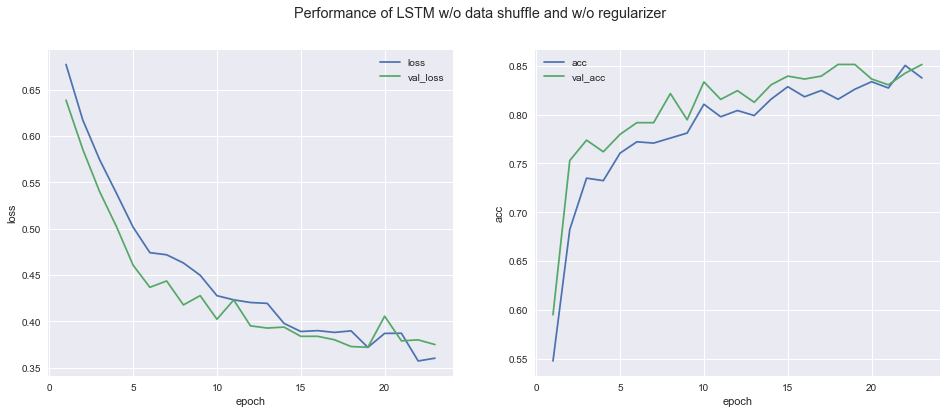

In [68]:
plot_history(history_try,'Performance of LSTM w/o data shuffle and w/o regularizer')

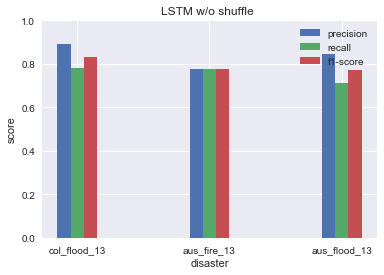

In [65]:
p, r, f = metric_drawing('LSTM w/o shuffle ', path='bi_lstm_no_con.h5')

In [66]:
print p, r, f

[0.89238410596026485, 0.77574750830564787, 0.84642857142857142] [0.78002894356005792, 0.77574750830564787, 0.71278195488721807] [0.83243243243243248, 0.77574750830564787, 0.77387755102040812]


In [67]:
increment_learning_result(path='bi_lstm_no_con.h5')

917/917 [==============================] - 6s 7ms/step
[0.5041632603533005, 0.76335877901595184]
917/917 [==============================] - 2s 2ms/step
[0.46718620343972711, 0.82224645622423975]
1079/1079 [==============================] - 7s 6ms/step
[0.504608284250468, 0.74976830337752443]
1079/1079 [==============================] - 2s 2ms/step
[0.53269847683380667, 0.76088971208929468]
1112/1112 [==============================] - 7s 7ms/step
[0.54829769361790992, 0.75089928100434999]
1112/1112 [==============================] - 2s 2ms/step
[0.61113654816750995, 0.73381294964028776]
917/917 [==============================] - 7s 8ms/step
[0.5041632603533005, 0.76335877901595184]
917/917 [==============================] - 2s 2ms/step
[0.46675412377978359, 0.80370774309403759]
1079/1079 [==============================] - 7s 6ms/step
[0.504608284250468, 0.74976830337752443]
1079/1079 [==============================] - 2s 2ms/step
[0.52754312002404735, 0.7618164961486088]
1112/1112 [====

In [47]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0.01, dropout=0.3, re_dropout=0.3)
history8=shuffle_train(lstm_model, col_fire_12, col_fire_12_g, 'lstm_shuffle.h5')

Train on 781 samples, validate on 336 samples
Epoch 1/10
781/781 [==============================] - 16s 21ms/step - loss: 4.4776 - acc: 0.5519 - val_loss: 4.2480 - val_acc: 0.6161
Epoch 2/10
781/781 [==============================] - 4s 6ms/step - loss: 4.1202 - acc: 0.6248 - val_loss: 3.9043 - val_acc: 0.6935
Epoch 3/10
781/781 [==============================] - 4s 6ms/step - loss: 3.7943 - acc: 0.6773 - val_loss: 3.5887 - val_acc: 0.7530
Epoch 4/10
781/781 [==============================] - 5s 6ms/step - loss: 3.4937 - acc: 0.7106 - val_loss: 3.2960 - val_acc: 0.7649
Epoch 5/10
781/781 [==============================] - 4s 6ms/step - loss: 3.2161 - acc: 0.7337 - val_loss: 3.0350 - val_acc: 0.7768
Epoch 6/10
781/781 [==============================] - 4s 6ms/step - loss: 2.9730 - acc: 0.7529 - val_loss: 2.8101 - val_acc: 0.7857
Epoch 7/10
781/781 [==============================] - 5s 7ms/step - loss: 2.7369 - acc: 0.7759 - val_loss: 2.6109 - val_acc: 0.7857
Epoch 8/10
781/781 [========

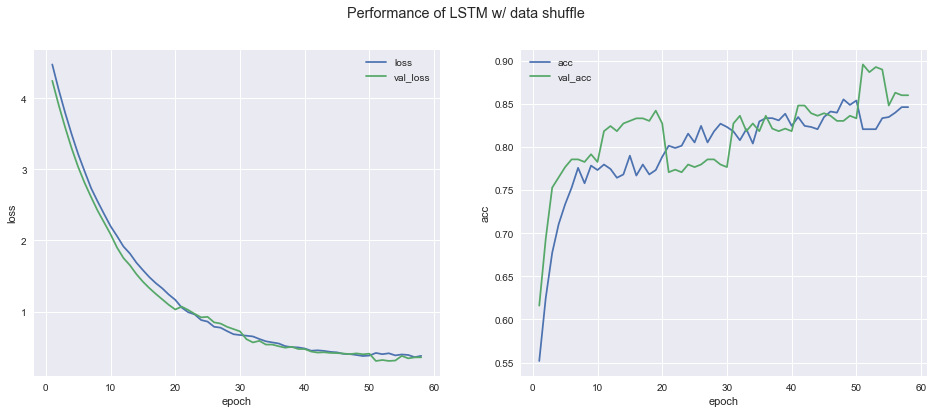

In [54]:
plot_history(history8, 'Performance of LSTM w/ data shuffle', dictionary=True)

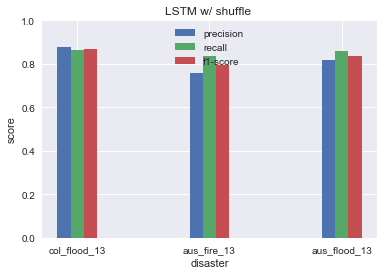

In [49]:
p, r, f = metric_drawing('LSTM w/ shuffle ', path='lstm_shuffle.h5')

In [50]:
print p, r, f

[0.87776141384388806, 0.76018099547511309, 0.8177905308464849] [0.86251808972503619, 0.83720930232558144, 0.8571428571428571] [0.87007299270072991, 0.79683794466403157, 0.83700440528634357]


In [51]:
increment_learning_result(path='lstm_shuffle.h5')

917/917 [==============================] - 5s 5ms/step
[0.49254186079312307, 0.80588876804582688]
917/917 [==============================] - 2s 2ms/step
[0.55228132107005645, 0.81679389345476905]
1079/1079 [==============================] - 6s 5ms/step
[0.54301177626743269, 0.7618164961486088]
1079/1079 [==============================] - 2s 2ms/step
[0.7193687151603062, 0.77015755290339893]
1112/1112 [==============================] - 5s 5ms/step
[0.50576583665909525, 0.80035971223021585]
1112/1112 [==============================] - 2s 2ms/step
[0.62303131068353168, 0.80215827338129497]
917/917 [==============================] - 5s 5ms/step
[0.49254186079312307, 0.80588876804582688]
917/917 [==============================] - 1s 2ms/step
[0.55087009660550268, 0.81897491853655746]
1079/1079 [==============================] - 6s 6ms/step
[0.54301177626743269, 0.7618164961486088]
1079/1079 [==============================] - 2s 2ms/step
[0.70199448118837371, 0.76923076862312223]
1112/1112 [

In [ ]:
%%time
lstm_model = create_lstm_model(n_lstm=64, penalty=0.01, dropout=0.3, re_dropout=0.3)
history8=shuffle_train(lstm_model, col_fire_12, col_fire_12_g, 'lstm_shuffle.h5')

In [25]:
model.evaluate(x=col_flood_13_g, y=col_flood_13.label)

917/917 [==============================] - 2s 2ms/step


[0.47805090493958285, 0.79280261749009662]

In [191]:
model.evaluate(x=col_flood_13_g, y=col_flood_13.label)

917/917 [==============================] - 2s 2ms/step


[2.3563455324168059, 0.75354416575790617]

In [26]:
model.evaluate(x=aus_fire_13_g, y=aus_fire_13.label)

1079/1079 [==============================] - 2s 2ms/step


[0.50584490366618429, 0.76367006537204984]

In [194]:
model.evaluate(x=aus_fire_13_g, y=aus_fire_13.label)

1079/1079 [==============================] - 2s 2ms/step


[4.1174695312811114, 0.5579240036242753]

In [27]:
model.evaluate(x=aus_flood_13_g, y=aus_flood_13.label)

1112/1112 [==============================] - 2s 2ms/step


[0.47785081751912617, 0.79136690604600979]

In [52]:
model.evaluate(x=col_fire_12_g, y=col_fire_12.label)

1117/1117 [==============================] - 2s 2ms/step


[0.3666660382529936, 0.84959713491672051]

In [52]:
model.metrics_names

['loss', 'acc']

In [ ]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB') # or'LR'

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [195]:
######################w/o domain adaption (baseline)####################################
cnn_model.evaluate(x=col_flood_13_g, y=col_flood_13.label)

917/917 [==============================] - 0s 78us/step


[0.50540405654855225, 0.78953107999741312]

In [204]:
cnn_model.evaluate(x=aus_fire_13_g, y=aus_fire_13.label)

1079/1079 [==============================] - 0s 86us/step


[0.61565139505794686, 0.74513438418576627]

In [202]:
cnn_model.evaluate(x=aus_fire_13_g, y=aus_fire_13.label)

1079/1079 [==============================] - 0s 84us/step


[0.60118024729268216, 0.7479147359217837]

In [197]:
cnn_model.evaluate(x=aus_flood_13_g, y=aus_flood_13.label)

1112/1112 [==============================] - 0s 103us/step


[0.5857864794113653, 0.7598920863309353]

In [198]:
cnn_model.evaluate(x=col_fire_12_g, y=col_fire_12.label)

1117/1117 [==============================] - 0s 101us/step


[0.50137588747292627, 0.82005371562903118]

In [211]:
######################try hard label in one go####################################
model1 = cnn_model
cf, lb_cf = hard_label(model1, col_flood_13_g, confidence=0.9)
af, lb_af = hard_label(model1, aus_fire_13_g, confidence=0.9)
qf, lb_qf = hard_label(model1, aus_flood_13_g, confidence=0.9)

In [213]:
df = np.vstack((cf,af,qf))

In [216]:
lb = np.vstack((lb_cf,lb_af,lb_qf))

In [217]:
model1.fit(df,lb)

Epoch 1/1
81/81 [==============================] - 0s 265us/step - loss: 0.2679 - acc: 0.9630


In [218]:
model1.evaluate(x=col_flood_13_g, y=col_flood_13.label)

917/917 [==============================] - 0s 84us/step


[0.52306050738175536, 0.79498364257188503]

In [219]:
model1.evaluate(x=aus_fire_13_g, y=aus_fire_13.label)

1079/1079 [==============================] - 0s 84us/step


[0.59871983798816319, 0.73030583857385178]

In [220]:
model1.evaluate(x=aus_flood_13_g, y=aus_flood_13.label)

1112/1112 [==============================] - 0s 84us/step


[0.61601999294843601, 0.7149280571251464]

In [ ]:
######################try weighted label incremental learning####################################

In [440]:
incremental_learning_em_v2(cnn_model, col_flood_13_g, step=5, threshold=0.5)

In [441]:
cnn_model.evaluate(x=col_flood_13_g, y=col_flood_13.label)

917/917 [==============================] - 0s 92us/step


[0.56187313801589678, 0.75572519122969228]

In [442]:
incremental_learning_em_v2(cnn_model, aus_fire_13_g, step=5, threshold=0.5)

In [443]:
cnn_model.evaluate(x=aus_fire_13_g, y=aus_fire_13.label)

1079/1079 [==============================] - 0s 98us/step


[0.60983065646262602, 0.68118628387212532]

In [444]:
incremental_learning_em_v2(cnn_model, aus_flood_13_g, step=5, threshold=0.5)

In [445]:
cnn_model.evaluate(x=aus_flood_13_g, y=aus_flood_13.label)

1112/1112 [==============================] - 0s 99us/step


[0.6267756918351427, 0.69964028776978415]

In [446]:
######################try hard label incremental learning with train on batch####################################

In [344]:
incremental_learning_hl(cnn_model, col_flood_13_g, step=10, confidence=0.9)

In [345]:
cnn_model.evaluate(x=col_flood_13_g, y=col_flood_13.label)

917/917 [==============================] - 0s 93us/step


[0.50252849406348454, 0.77644492918168451]

In [346]:
incremental_learning_hl(cnn_model, aus_fire_13_g, step=10, confidence=0.9)

In [347]:
cnn_model.evaluate(x=aus_fire_13_g, y=aus_fire_13.label)

1079/1079 [==============================] - 0s 90us/step


[0.99852934990689313, 0.56533827609878873]

In [348]:
incremental_learning_hl(cnn_model, aus_flood_13_g, step=10, confidence=0.9)

In [349]:
cnn_model.evaluate(x=aus_flood_13_g, y=aus_flood_13.label)

1112/1112 [==============================] - 0s 94us/step


[1.2142007942679975, 0.5998201434560817]

In [292]:
#WRONG#####################try hard label incremental learning with fit ####################################

In [302]:
def incremental_learning_hl_fit(model, tweets, step=10, confidence=0.95):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence]
        label = to_categorical(map(lambda x: 0 if x[0]>=confidence else 1, y_confident))
        model.fit(x_confident, label, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [304]:
incremental_learning_hl_fit(cnn_model, col_flood_13_g, step=10, confidence=0.9)

Train on 9 samples, validate on 5 samples
Epoch 1/10
9/9 [==============================] - 0s 785us/step - loss: 0.1652 - acc: 0.8889 - val_loss: 0.1005 - val_acc: 1.0000
Epoch 2/10
9/9 [==============================] - 0s 801us/step - loss: 0.1808 - acc: 0.8889 - val_loss: 0.0998 - val_acc: 1.0000
Epoch 3/10
9/9 [==============================] - 0s 802us/step - loss: 0.1635 - acc: 0.8889 - val_loss: 0.0985 - val_acc: 1.0000
Epoch 4/10
9/9 [==============================] - 0s 819us/step - loss: 0.4816 - acc: 0.5556 - val_loss: 0.0963 - val_acc: 1.0000
Epoch 5/10
9/9 [==============================] - 0s 796us/step - loss: 0.2871 - acc: 0.7778 - val_loss: 0.0929 - val_acc: 1.0000
Epoch 6/10
9/9 [==============================] - 0s 790us/step - loss: 0.1805 - acc: 0.8889 - val_loss: 0.0890 - val_acc: 1.0000
Epoch 7/10
9/9 [==============================] - 0s 800us/step - loss: 0.2794 - acc: 0.7778 - val_loss: 0.0847 - val_acc: 1.0000
Epoch 8/10
9/9 [==============================] 

Train on 62 samples, validate on 27 samples
Epoch 1/10
62/62 [==============================] - 0s 356us/step - loss: 0.2389 - acc: 0.7258 - val_loss: 0.0504 - val_acc: 1.0000
Epoch 2/10
62/62 [==============================] - 0s 343us/step - loss: 0.2025 - acc: 0.7742 - val_loss: 0.0500 - val_acc: 1.0000
Epoch 3/10
62/62 [==============================] - 0s 385us/step - loss: 0.2469 - acc: 0.7097 - val_loss: 0.0495 - val_acc: 1.0000
Epoch 4/10
62/62 [==============================] - 0s 350us/step - loss: 0.1909 - acc: 0.7903 - val_loss: 0.0491 - val_acc: 1.0000
Epoch 5/10
62/62 [==============================] - 0s 377us/step - loss: 0.2108 - acc: 0.7581 - val_loss: 0.0486 - val_acc: 1.0000
Epoch 6/10
62/62 [==============================] - 0s 383us/step - loss: 0.1885 - acc: 0.7903 - val_loss: 0.0482 - val_acc: 1.0000
Epoch 7/10
62/62 [==============================] - 0s 373us/step - loss: 0.2204 - acc: 0.7419 - val_loss: 0.0478 - val_acc: 1.0000
Epoch 8/10
62/62 [==============

In [305]:
cnn_model.evaluate(x=col_flood_13_g, y=col_flood_13.label)

917/917 [==============================] - 0s 90us/step


[1.2957878456072174, 0.75354416575790617]

In [306]:
incremental_learning_hl_fit(cnn_model, aus_fire_13_g, step=10, confidence=0.9)

Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 0s 448us/step - loss: 0.2243 - acc: 1.0000 - val_loss: 0.0413 - val_acc: 1.0000
Epoch 2/10
67/67 [==============================] - 0s 397us/step - loss: 0.2056 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 1.0000
Epoch 3/10
67/67 [==============================] - 0s 430us/step - loss: 0.1983 - acc: 1.0000 - val_loss: 0.0402 - val_acc: 1.0000
Epoch 4/10
67/67 [==============================] - 0s 407us/step - loss: 0.1790 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 1.0000
Epoch 5/10
67/67 [==============================] - 0s 441us/step - loss: 0.1156 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 1.0000
Epoch 6/10
67/67 [==============================] - 0s 419us/step - loss: 0.2451 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 1.0000
Epoch 7/10
67/67 [==============================] - 0s 446us/step - loss: 0.2257 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 1.0000
Epoch 8/10
67/67 [==============

74/74 [==============================] - 0s 451us/step - loss: 0.1364 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 1.0000
Epoch 2/10
74/74 [==============================] - 0s 412us/step - loss: 0.1478 - acc: 1.0000 - val_loss: 0.0306 - val_acc: 1.0000
Epoch 3/10
74/74 [==============================] - 0s 431us/step - loss: 0.1054 - acc: 1.0000 - val_loss: 0.0305 - val_acc: 1.0000
Epoch 4/10
74/74 [==============================] - 0s 420us/step - loss: 0.1285 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 1.0000
Epoch 5/10
74/74 [==============================] - 0s 449us/step - loss: 0.1694 - acc: 1.0000 - val_loss: 0.0303 - val_acc: 1.0000
Epoch 6/10
74/74 [==============================] - 0s 459us/step - loss: 0.1278 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 1.0000
Epoch 7/10
74/74 [==============================] - 0s 498us/step - loss: 0.1329 - acc: 1.0000 - val_loss: 0.0300 - val_acc: 1.0000
Epoch 8/10
74/74 [==============================] - 0s 503us/step - loss: 0.1382 - acc:

In [307]:
cnn_model.evaluate(x=aus_fire_13_g, y=aus_fire_13.label)

1079/1079 [==============================] - 0s 105us/step


[3.0058222650045372, 0.5579240036242753]

In [308]:
incremental_learning_hl_fit(cnn_model, aus_flood_13_g, step=10, confidence=0.9)

Train on 77 samples, validate on 34 samples
Epoch 1/10
77/77 [==============================] - 0s 351us/step - loss: 0.1127 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 1.0000
Epoch 2/10
77/77 [==============================] - 0s 344us/step - loss: 0.1016 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 1.0000
Epoch 3/10
77/77 [==============================] - 0s 344us/step - loss: 0.0965 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 1.0000
Epoch 4/10
77/77 [==============================] - 0s 325us/step - loss: 0.1214 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 1.0000
Epoch 5/10
77/77 [==============================] - 0s 341us/step - loss: 0.1109 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 1.0000
Epoch 6/10
77/77 [==============================] - 0s 368us/step - loss: 0.1201 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 1.0000
Epoch 7/10
77/77 [==============================] - 0s 333us/step - loss: 0.1235 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 1.0000
Epoch 8/10
77/77 [==============

77/77 [==============================] - 0s 412us/step - loss: 0.0860 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 1.0000
Epoch 2/10
77/77 [==============================] - 0s 385us/step - loss: 0.0896 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 1.0000
Epoch 3/10
77/77 [==============================] - 0s 416us/step - loss: 0.1037 - acc: 1.0000 - val_loss: 0.0197 - val_acc: 1.0000
Epoch 4/10
77/77 [==============================] - 0s 448us/step - loss: 0.0728 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 1.0000
Epoch 5/10
77/77 [==============================] - 0s 450us/step - loss: 0.0958 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 6/10
77/77 [==============================] - 0s 494us/step - loss: 0.0919 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 7/10
77/77 [==============================] - 0s 589us/step - loss: 0.1059 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 1.0000
Epoch 8/10
77/77 [==============================] - 0s 531us/step - loss: 0.1099 - acc:

In [309]:
cnn_model.evaluate(x=aus_flood_13_g, y=aus_flood_13.label)

1112/1112 [==============================] - 0s 97us/step


[2.8660263826521182, 0.59802158230500257]

In [400]:
from Dataset_T6 import dataset_T6

In [406]:
sandy = dataset_T6('2012_Sandy_Hurricane/2012_Sandy_Hurricane-ontopic_offtopic.csv')

In [408]:
x = sandy.glove(embedding_index, vtr_dim)

In [414]:
x_train, x_test, y_train, y_test = train_test_split(x, sandy.label, test_size=0.3)

In [424]:
def create_cnn_model(n_conv1=64,n_conv2=32, n_conv3=16, window_1=3, window_2=3, window_3=3, dropout=0.3):
    model = Sequential()
    model.add(Conv1D(n_conv1, window_1, activation='relu', kernel_initializer = 'glorot_normal', 
                   kernel_regularizer=regularizers.l2(0.01), input_shape=(None,25)))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(n_conv2, window_2, activation='relu', kernel_initializer = 'glorot_normal', 
                   kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(n_conv1, window_3, activation='relu', kernel_initializer = 'glorot_normal', 
               kernel_regularizer=regularizers.l2(0.01), input_shape=(None,25)))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model(32,16,8,3,3,3,0.5)
cnn_model.fit(x_train, y_train, callbacks=[es], validation_split=0.3, batch_size=64, epochs=100)

Train on 4903 samples, validate on 2102 samples
Epoch 1/100
4903/4903 [==============================] - 5s 941us/step - loss: 0.9947 - acc: 0.6580 - val_loss: 0.7605 - val_acc: 0.7788
Epoch 2/100
4903/4903 [==============================] - 1s 281us/step - loss: 0.6232 - acc: 0.8224 - val_loss: 0.4737 - val_acc: 0.8882
Epoch 3/100
4903/4903 [==============================] - 1s 283us/step - loss: 0.4661 - acc: 0.8805 - val_loss: 0.3919 - val_acc: 0.9115
Epoch 4/100
4903/4903 [==============================] - 1s 287us/step - loss: 0.4224 - acc: 0.8956 - val_loss: 0.3642 - val_acc: 0.9144
Epoch 5/100
4903/4903 [==============================] - 2s 320us/step - loss: 0.3913 - acc: 0.9023 - val_loss: 0.3535 - val_acc: 0.9144
Epoch 6/100
4903/4903 [==============================] - 1s 279us/step - loss: 0.3744 - acc: 0.9060 - val_loss: 0.3421 - val_acc: 0.9096
Epoch 7/100
4903/4903 [==============================] - 1s 278us/step - loss: 0.3589 - acc: 0.9078 - val_loss: 0.3304 - val_acc: 

In [426]:
lstm_model = Sequential()
#model.add(Embedding(col_fire_12.vocab_size, output_dim=20, embeddings_initializer='glorot_normal'))
lstm_model.add(Bidirectional(LSTM(32, kernel_initializer='glorot_normal', recurrent_dropout=0.5, dropout=0.5, 
                             kernel_regularizer=regularizers.l2(0.01)),input_shape=(None,25)))
lstm_model.add(Dense(64, activation='relu',kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, callbacks=[es], validation_split=0.3, batch_size=64, epochs=100)

Train on 4903 samples, validate on 2102 samples
Epoch 1/100
4903/4903 [==============================] - 28s 6ms/step - loss: 0.7563 - acc: 0.6041 - val_loss: 0.5615 - val_acc: 0.7712
Epoch 2/100
4903/4903 [==============================] - 26s 5ms/step - loss: 0.5664 - acc: 0.7277 - val_loss: 0.4552 - val_acc: 0.8083
Epoch 3/100
4903/4903 [==============================] - 25s 5ms/step - loss: 0.4888 - acc: 0.7987 - val_loss: 0.3317 - val_acc: 0.8839
Epoch 4/100
4903/4903 [==============================] - 26s 5ms/step - loss: 0.4442 - acc: 0.8338 - val_loss: 0.3129 - val_acc: 0.8958
Epoch 5/100
4903/4903 [==============================] - 26s 5ms/step - loss: 0.4218 - acc: 0.8485 - val_loss: 0.2885 - val_acc: 0.9072
Epoch 6/100
4903/4903 [==============================] - 26s 5ms/step - loss: 0.4041 - acc: 0.8550 - val_loss: 0.2821 - val_acc: 0.9091
Epoch 7/100
4903/4903 [==============================] - 26s 5ms/step - loss: 0.4041 - acc: 0.8585 - val_loss: 0.3075 - val_acc: 0.8944


In [429]:
lstm_model.evaluate(aus_fire_13_g, aus_fire_13.label)

1079/1079 [==============================] - 2s 2ms/step


[1.4884668448327094, 0.56070435580221778]